In [56]:
%pylab inline
import numpy as np
import theano
import theano.tensor as T
from theano import pp
from scipy.spatial.distance import pdist, cdist
import sys
import cPickle as pickle
import time
sys.path.append("../")
import sgd


Populating the interactive namespace from numpy and matplotlib


In [35]:
# now the actual distance function
theta = T.dvector('theta')
xv = T.dvector('xv')
xconst = T.dmatrix('xconst')
scale = T.scalar('scale')


similarity = scale/((xv -xconst)**2 + 2.0).sum(1)

def poisson_ll(k, lamb):
    return k * T.log(lamb) - lamb - T.gammaln(k+1)


def norm_unitvar_ll(obs, mu):
    return -(obs - mu)**2
    
similarity_f = theano.function([scale, xv, xconst], similarity)
ll = T.sum(norm_unitvar_ll(theta, similarity))
ll_f = theano.function([scale, theta, xconst, xv], ll)
ll_grad = T.grad(ll, xv)
ll_grad_f = theano.function([scale, theta, xconst, xv], ll_grad)


In [36]:
def total_ll(scale, obs, x):

    score = 0.0

    for i in range(N):
        score += ll_f(scale, np.delete(obs[i], i, 0), np.delete(x, i, 0), x[i])
    return score


def forward_model_lamb(SCALE, x ):
    sim_matrix = np.zeros((N, N))
    for xi in range(N):
        sim_matrix[xi] = similarity_f(SCALE, x[xi], x)
    sim_matrix[np.diag_indices(N)] = 0.0
    obs = np.random.normal(sim_matrix, 0.00001)
    return obs


In [37]:

np.random.seed(0)
N = 40
BATCH_SIZE = 10
DIM = 2
SCALE = 40.0
XINIT_VAR = 5.0
# fake data
xtrue = np.random.normal(0, XINIT_VAR, (N, DIM))
obs = forward_model_lamb(SCALE, xtrue)


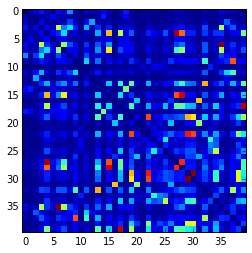

In [38]:
pylab.imshow(obs, interpolation='nearest') #, vmin=0, vmax=20)

In [49]:
np.random.seed(100)

def flatten(obs, x):
    N = len(x)
    Na = N*(N-1)/2
    x1flat = np.zeros((Na, x.shape[1]))
    x2flat = np.zeros((Na, x.shape[1]))

    obsflat = np.zeros((Na)) 
    pos = 0
    for i in range(N):
        for j in range(N):
            if j > i:
                obsflat[pos] = obs[i, j]
                x1flat[pos] = x[i]
                x2flat[pos] = x[j]
                pos += 1
    return x1flat, x2flat, obsflat



  
#print np.sum((x1flat -x2flat)**2, axis=1)
print "actual log likelihood of obs", total_ll(SCALE, obs, xtrue)


ITERS = 40000
xk = np.random.normal(0, XINIT_VAR, (N, DIM))

val_present = np.random.rand(N, N) < 0.80

alpha = 0.5
num_batches =  N//BATCH_SIZE

use_adagrad = True
use_momentum = False
grad_hists = np.zeros((N, DIM)) # for each param
runlog = []
t1 = time.time()
for k in range(ITERS):
    # pick fixed indicies
    perm = np.random.permutation(N)
    for xv_i in perm:

        points = np.array([p for p in range(N) if val_present[xv_i, p] and p != xv_i ])
        # random subset
        #points = np.random.permutation(points)[:10]
        #print "xv_i=", xv_i, "points are", points
        fixed_vals = xk[points]
        xv = xk[xv_i]

        ks = obs[xv_i, points]

        grad =  ll_grad_f(SCALE, ks, fixed_vals, xv)
       
        if use_adagrad :
            grad_norm  = grad**2
            grad_hists[xv_i] += grad_norm
            alpha_k = alpha / np.sqrt(grad_hists[xv_i])
        elif use_momentum:
            orig_grad = grad.copy()
            if k > 0:
                grad = grad* 0.9 # + grad_hists[xv_i] * 0.1
            
            grad_hists[xv_i] = orig_grad
            
            alpha_k = alpha
        else:
            alpha_k = alpha

            
        xk[xv_i] = xv + alpha_k * grad
        #print "ll change by",  total_ll(SCALE, obs, xk) - pre_ll

    if k % 100 == 0:
        obsest = forward_model_lamb(SCALE, xk )
        l1err = np.sum(np.abs(obsest - obs))
        total_ll_val = total_ll(SCALE, obs, xk)
        runlog.append((k, total_ll_val, l1err, xk.copy(), obsest))
        print k,  total_ll_val, l1err, (time.time() - t1)/60, "min"

actual log likelihood of obs -1.50121441698e-07
0 -5775.83606541 1818.92274765 0.000176433722178 min
100 -3608.65321715 1268.09531676 0.00724141597748 min
200 -3395.88204428 1180.9928047 0.0142683664958 min
300 -3330.19093026 1174.10457192 0.0213629484177 min
400 -2091.88102669 919.396390771 0.0283970316251 min
500 -1846.70313695 860.079653848 0.0354660987854 min
600 -1720.3122342 818.149195819 0.0425007979075 min
700 -1671.33444514 804.023585115 0.0495313167572 min
800 -1651.06246693 800.50103298 0.0566576480865 min
900 -1596.13830394 791.138603574 0.0636895298958 min
1000 -1571.37172109 784.120974326 0.0707152485847 min
1100 -1086.61567207 707.081610731 0.0778013825417 min
1200 -987.571613935 646.221019152 0.084830947717 min
1300 -970.299306475 636.284939867 0.0918637474378 min
1400 -933.636275587 626.546511062 0.0989260156949 min
1500 -859.044186792 611.344401107 0.105952314536 min
1600 -857.840453056 611.083761874 0.112980747223 min
1700 -857.292705678 610.673079654 0.120025797685 

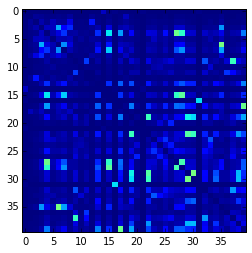

In [50]:
obs_est = forward_model_lamb(SCALE, xk)
VMIN = 0
VMAX = 20
pylab.imshow(obs_est, interpolation='nearest', vmin=VMIN, vmax=VMAX)

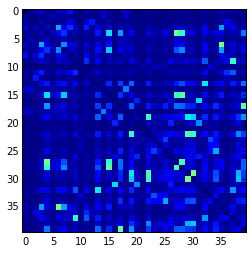

In [51]:
pylab.imshow(obs, interpolation='nearest', vmin=VMIN, vmax=VMAX)

In [52]:
missing_pos = np.argwhere(val_present < 1)
true_vals = obs[missing_pos[:, 0], missing_pos[:, 1]]
est_vals = obs_est[missing_pos[:, 0], missing_pos[:, 1]]
print len(true_vals)
print len(est_vals)

298
298


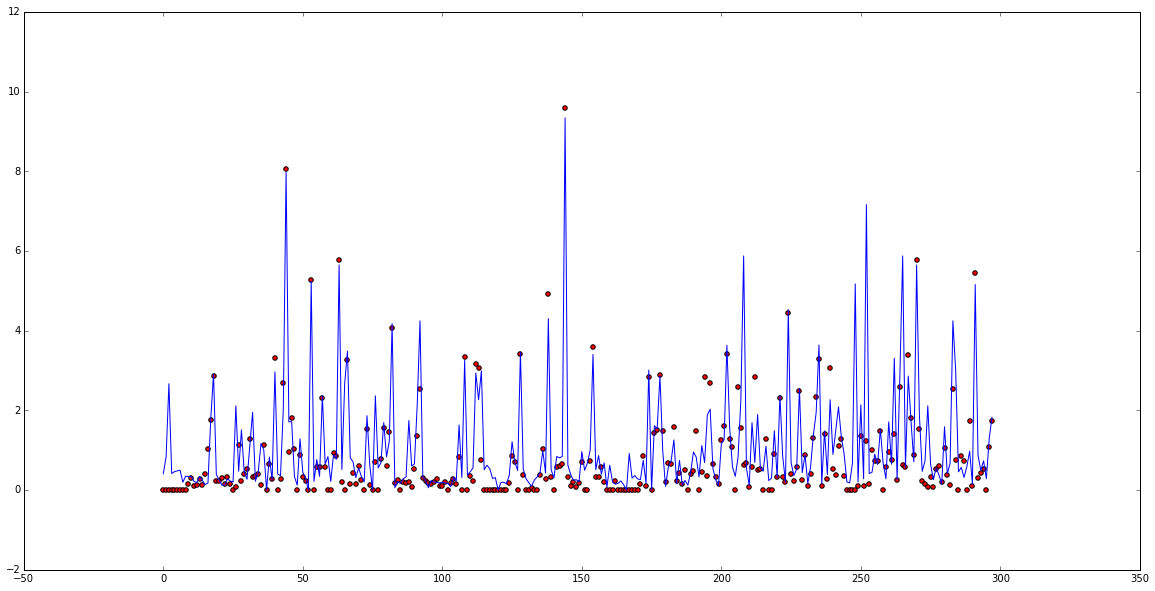

In [53]:
pylab.figure(figsize=(20, 10))
pylab.plot(true_vals)
pylab.scatter(range(len(est_vals)), est_vals, c='r')


In [65]:

reload(sgd)
def sim_func(xv, xconst):
    similarity = SCALE/((xv -xconst)**2 + 2.0).sum(1)
    return similarity 

def norm_unitvar_ll(obs, mu):
    return -(obs - mu)**2

xinit = np.random.normal(0, XINIT_VAR, (N, DIM))


def forward_model_lamb(SCALE, x ):
    sim_matrix = np.zeros((N, N))
    for xi in range(N):
        sim_matrix[xi] = similarity_f(SCALE, x[xi], x)
    sim_matrix[np.diag_indices(N)] = 0.0
    obs = np.random.normal(sim_matrix, 0.00001)
    return obs

obs = forward_model_lamb(SCALE, xtrue)

val_present = np.random.rand(N, N) < 0.80



res = sgd.run_sgd(sim_func, norm_unitvar_ll, xinit, obs, 
       val_present, ITERS=4000)



0 -5834.44330537 0.000101315975189 min
100 -3456.2551658 0.00576264858246 min
200 -3150.37381428 0.0114268143972 min
300 -2957.34815392 0.0170957167943 min
400 -1887.95398142 0.0227728009224 min
500 -1686.93122522 0.0284432331721 min
600 -1634.85106826 0.0341007153193 min
700 -1580.62323281 0.0397694826126 min
800 -905.105677846 0.0454419493675 min
900 -752.203914323 0.0511124809583 min
1000 -710.839706525 0.056770881017 min
1100 -704.77021031 0.0624479810397 min
1200 -698.318981258 0.0681141495705 min
1300 -689.532351642 0.0737886309624 min
1400 -679.126305887 0.0794567147891 min
1500 -667.291646719 0.085130349795 min
1600 -655.441804331 0.0908020178477 min
1700 -646.312870969 0.0964811166128 min
1800 -631.120239575 0.102149899801 min
1900 -611.289702381 0.107826550802 min
2000 -609.55274538 0.113503348827 min
2100 -607.890975812 0.119176665942 min
2200 -606.168301811 0.124831183751 min
2300 -604.234552279 0.13049018383 min
2400 -601.215283795 0.136153300603 min
2500 -597.509774851 0.

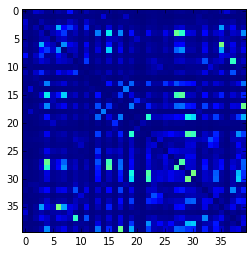

In [66]:
obs_est = forward_model_lamb(SCALE, res['x_est'])
VMIN = 0
VMAX = 20
pylab.imshow(obs_est, interpolation='nearest', vmin=VMIN, vmax=VMAX)

In [67]:
pylab.imshow(obs, interpolation='nearest', vmin=VMIN, vmax=VMAX)

297
297


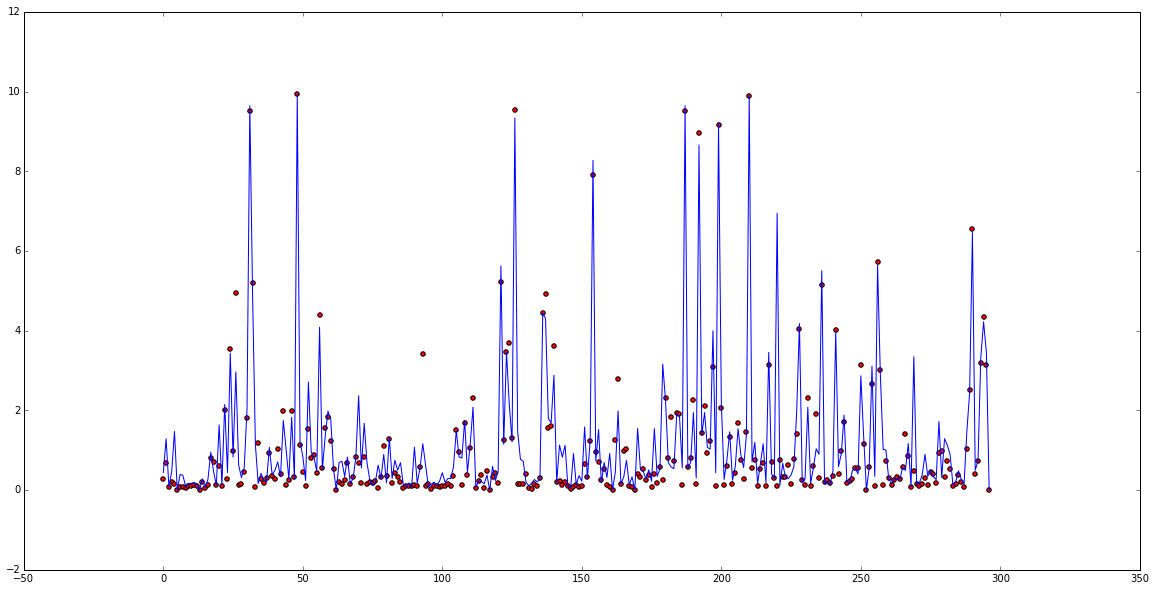

In [68]:
missing_pos = np.argwhere(val_present < 1)
true_vals = obs[missing_pos[:, 0], missing_pos[:, 1]]
est_vals = obs_est[missing_pos[:, 0], missing_pos[:, 1]]
print len(true_vals)
print len(est_vals)
pylab.figure(figsize=(20, 10))
pylab.plot(true_vals)
pylab.scatter(range(len(est_vals)), est_vals, c='r')
